In [1]:
#https://www.kaggle.com/carrie1/ecommerce-data

In [2]:
#env1

import numpy as np
import pandas as pd
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes import GammaGammaFitter

In [3]:
data=pd.read_csv("data.csv",encoding="ISO-8859-1",parse_dates=["InvoiceDate"])
data=data.drop_duplicates().reset_index(drop=True)
data=data[data["Country"]=="United Kingdom"]
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
536621,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
536622,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom
536623,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom
536624,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom


In [4]:
for _,row in data.iterrows():
    #for each refunded row, search for corresponding purchased row having the same quantity 
    if row["Quantity"]<0:
        purchase_row=data[(data["StockCode"]==row["StockCode"])&(data["Quantity"]==(row["Quantity"]*-1))&
                          (data["InvoiceDate"]<row["InvoiceDate"])&(data["CustomerID"]==row["CustomerID"])]
        #remove last purchased row having the same quantity
        if (purchase_row.shape[0]>0):
            index=purchase_row.iloc[[-1]].index[0]
            data=data.drop([index])
        #search for corresponding purchased row having a larger quantity
        else:
            purchase_row=data[(data["StockCode"]==row["StockCode"])&(data["Quantity"]>(row["Quantity"]*-1))&
                              (data["InvoiceDate"]<row["InvoiceDate"])&(data["CustomerID"]==row["CustomerID"])]
            #replace quantity of last purchased row with original quantity plus refunded quantity
            if (purchase_row.shape[0]>0):
                index=purchase_row.iloc[[-1]].index[0]
                data.loc[index,"Quantity"]+=row["Quantity"]
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
536621,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
536622,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom
536623,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom
536624,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom


In [5]:
data=data[data["Quantity"]>0]
data=data.dropna(subset=["CustomerID"])
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
536621,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
536622,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom
536623,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom
536624,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom


In [6]:
data["Price"]=data["Quantity"]*data["UnitPrice"]
data["Date"]=data["InvoiceDate"].dt.date
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
...,...,...,...,...,...,...,...,...,...,...
536621,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,23.40,2011-12-09
536622,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,23.60,2011-12-09
536623,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,30.00,2011-12-09
536624,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,214.80,2011-12-09


In [7]:
data=data[["CustomerID","Date","Price"]].reset_index(drop=True)
data

,CustomerID,Date,Price
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34
...,...,...,...
346848,15804.0,2011-12-09,23.40
346849,13113.0,2011-12-09,23.60
346850,13113.0,2011-12-09,30.00
346851,13113.0,2011-12-09,214.80


In [8]:
data.isnull().sum()

CustomerID    0
Date          0
Price         0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346853 entries, 0 to 346852
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CustomerID  346853 non-null  float64
 1   Date        346853 non-null  object 
 2   Price       346853 non-null  float64
dtypes: float64(2), object(1)
memory usage: 7.9+ MB


In [10]:
max_date=data["Date"].max()
max_date

datetime.date(2011, 12, 9)

In [11]:
#transform transactional data (one row per purchase) into summary data (a frequency, recency and age dataset)
df=summary_data_from_transaction_data(data,"CustomerID","Date",monetary_value_col="Price",observation_period_end=max_date)
df

,frequency,recency,T,monetary_value
CustomerID,,,,
12747.0,10.0,367.0,369.0,383.745000
12748.0,112.0,373.0,373.0,279.912143
12749.0,3.0,210.0,213.0,1028.700000
12820.0,3.0,323.0,326.0,257.293333
12821.0,0.0,0.0,214.0,0.000000
...,...,...,...,...
18280.0,0.0,0.0,277.0,0.000000
18281.0,0.0,0.0,180.0,0.000000
18282.0,1.0,119.0,126.0,77.840000


In [12]:
df.describe()

,frequency,recency,T,monetary_value
count,3913.000000,3913.000000,3913.000000,3913.000000
mean,2.839509,131.158957,223.015589,245.476135
std,5.696508,132.358742,118.070901,504.871522
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,112.000000,0.000000
50%,1.000000,93.000000,249.000000,170.506667
75%,3.000000,252.000000,327.000000,343.115000
max,112.000000,373.000000,373.000000,21535.900000


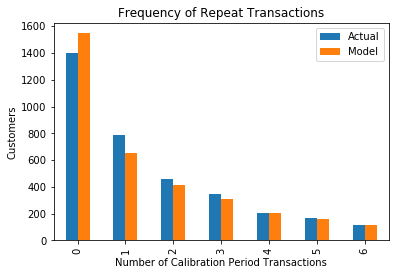

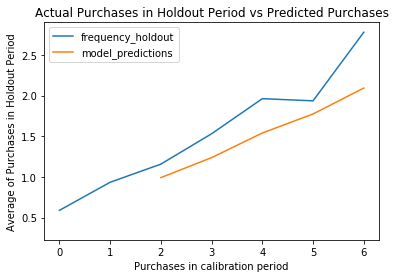

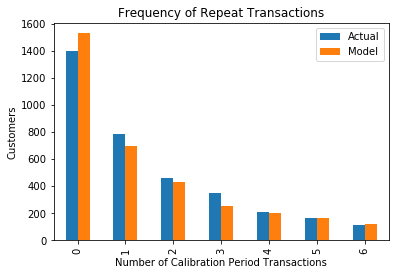

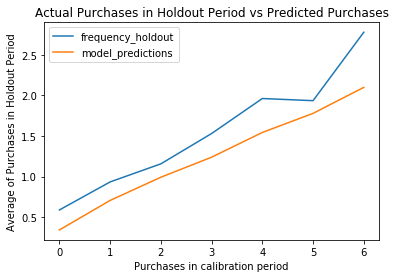

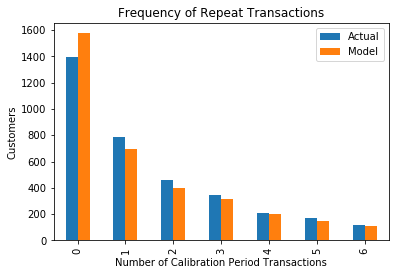

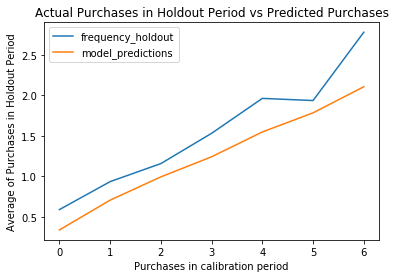

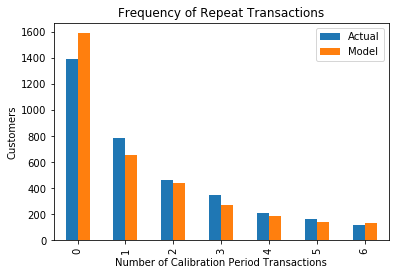

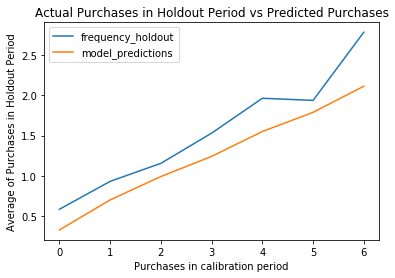

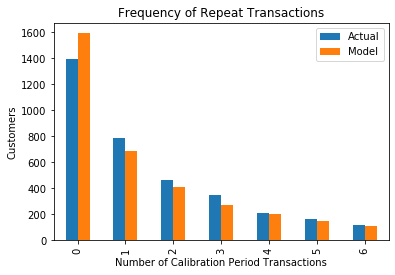

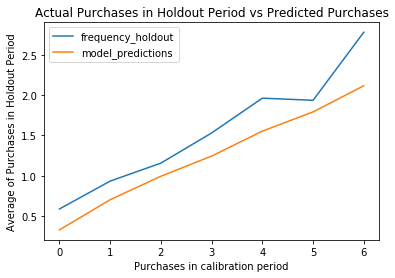

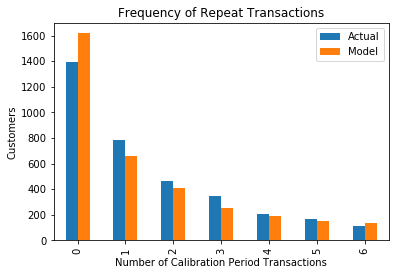

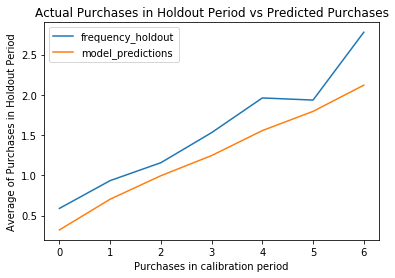

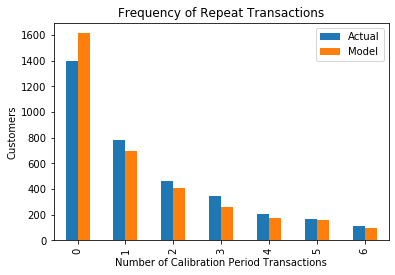

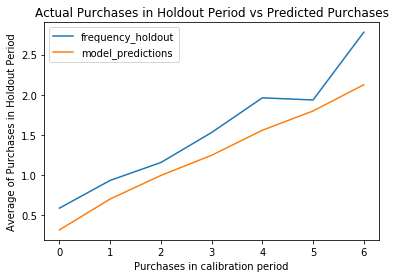

In [13]:
#search for BetaGeoFitter best penalizer coefficient
for value in np.linspace(0.04,0.1,7):
    bgf=BetaGeoFitter(penalizer_coef=value)
    bgf.fit(df["frequency"],df["recency"],df["T"])
    plot_period_transactions(bgf)
    summary_cal_holdout=calibration_and_holdout_data(data,"CustomerID","Date",calibration_period_end="2011-9-9",observation_period_end=max_date)
    bgf.fit(summary_cal_holdout["frequency_cal"],summary_cal_holdout["recency_cal"],summary_cal_holdout["T_cal"])
    plot_calibration_purchases_vs_holdout_purchases(bgf,summary_cal_holdout)

In [14]:
#frequency/recency analysis using the BG/NBD model
bgf=BetaGeoFitter(penalizer_coef=0.05)
bgf.fit(df["frequency"],df["recency"],df["T"])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 3913 subjects, a: 0.00, alpha: 56.35, b: 0.00, r: 0.67>


In [15]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,6.722770e-01,0.019110,0.634821,0.709733
alpha,5.634715e+01,2.023655,52.380788,60.313516
a,4.681643e-21,NaN,NaN,NaN
b,1.449066e-11,NaN,NaN,NaN


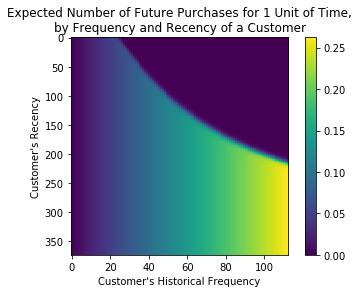

In [16]:
#visualise the frequency/recency matrix
#computes the expected number of transactions a artificial customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made)
plot_frequency_recency_matrix(bgf)

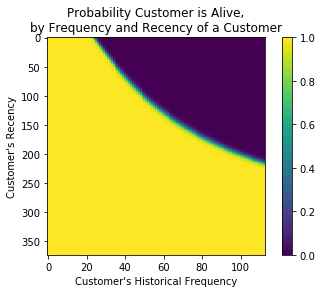

In [17]:
#visualise the frequency/recency matrix
#probability of still being alive
plot_probability_alive_matrix(bgf)

In [18]:
#ranking customers from best to worst
#predict a customer’s expected purchases in the next period using their history
#predicted_purchases is the predicted number of purchases
t=30
df["predicted_purchases"]=bgf.conditional_expected_number_of_purchases_up_to_time(t,df["frequency"],df["recency"],df["T"])
df.sort_values(by="predicted_purchases").tail(20)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
17961.0,34.0,351.0,372.0,34.379118,2.428330
17389.0,31.0,331.0,331.0,1018.417419,2.453015
13468.0,35.0,372.0,373.0,151.334286,2.492548
17315.0,34.0,356.0,357.0,180.851765,2.516452
13263.0,32.0,324.0,325.0,227.977188,2.570278
16029.0,38.0,335.0,373.0,1705.541053,2.702168
13408.0,40.0,372.0,373.0,672.078750,2.841915
17811.0,37.0,329.0,333.0,200.590811,2.902727
15189.0,37.0,331.0,332.0,417.108108,2.910201


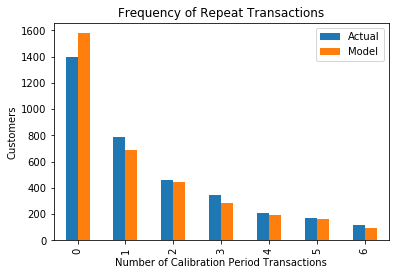

In [19]:
#assessing model fit
#method 1: compare data versus artificial data simulated with fitted model’s parameters
plot_period_transactions(bgf)

In [20]:
# assessing model fit
#method 2: partition the dataset into a calibration period dataset and a holdout dataset to test how the model performs on data not yet seen 
summary_cal_holdout=calibration_and_holdout_data(data,"CustomerID","Date",calibration_period_end="2011-9-9",observation_period_end=max_date)
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12747.0               7.0        260.0  278.0                3.0   
12748.0              72.0        282.0  282.0               40.0   
12749.0               1.0         83.0  122.0                2.0   
12820.0               0.0          0.0  235.0                3.0   
12821.0               0.0          0.0  123.0                0.0   

            duration_holdout  
CustomerID                    
12747.0                   91  
12748.0                   91  
12749.0                   91  
12820.0                   91  
12821.0                   91  


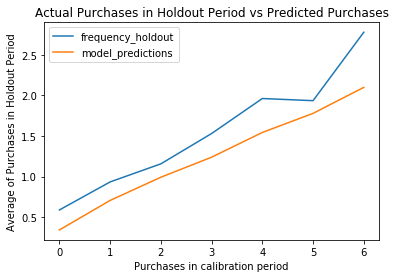

In [21]:
#perform fit on the _cal columns and test on the _holdout columns
bgf.fit(summary_cal_holdout["frequency_cal"],summary_cal_holdout["recency_cal"],summary_cal_holdout["T_cal"])
plot_calibration_purchases_vs_holdout_purchases(bgf,summary_cal_holdout)

In [22]:
#estimate customer lifetime value using the Gamma-Gamma model
returning_customers_summary=df[df["frequency"]>0]
print(returning_customers_summary.head())

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12747.0          10.0    367.0  369.0      383.745000             0.752722
12748.0         112.0    373.0  373.0      279.912143             7.872809
12749.0           3.0    210.0  213.0     1028.700000             0.409020
12820.0           3.0    323.0  326.0      257.293333             0.288137
12822.0           1.0     17.0   87.0      257.980000             0.349978


In [23]:
#the Gamma-Gamma model assumes that there is no relationship between the monetary value and the purchase frequency
#need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model
returning_customers_summary[["monetary_value","frequency"]].corr()

,monetary_value,frequency
monetary_value,1.000000,0.110253
frequency,0.110253,1.000000


In [24]:
#train the Gamma-Gamma model and predict the conditional, expected average lifetime value of the customers
ggf=GammaGammaFitter(penalizer_coef=0)
ggf.fit(returning_customers_summary["frequency"],returning_customers_summary["monetary_value"])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2516 subjects, p: 2.08, q: 3.90, v: 534.24>


In [25]:
#estimate the average transaction value
print(ggf.conditional_expected_average_profit(df["frequency"],df["monetary_value"]).head(10))

CustomerID
12747.0    383.613665
12748.0    281.177276
12749.0    823.539823
12820.0    297.110391
12821.0    382.672918
12822.0    330.632293
12823.0    368.367750
12824.0    382.672918
12826.0    249.775627
12827.0    219.853532
dtype: float64


In [26]:
print("Expected conditional average profit: %s, Average profit: %s"% 
      (ggf.conditional_expected_average_profit(df["frequency"],df["monetary_value"]).mean(),
       df[df["frequency"]>0]["monetary_value"].mean()))

Expected conditional average profit: 388.2115011528745, Average profit: 381.7758803672973


In [1]:
import numpy as np
import pandas as pd
import datetime as dt

from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

In [2]:
def clean_data(data):
    
    data=pd.read_csv(data,encoding="ISO-8859-1",parse_dates=["InvoiceDate"])
    data=data.drop_duplicates().reset_index(drop=True)
    data=data[data["Country"]=="United Kingdom"]
    
    for _,row in data.iterrows():
        if row["Quantity"]<0:
            purchase_row=data[(data["StockCode"]==row["StockCode"])&(data["Quantity"]==(row["Quantity"]*-1))&
                              (data["InvoiceDate"]<row["InvoiceDate"])&(data["CustomerID"]==row["CustomerID"])]
            if (purchase_row.shape[0]>0):
                index=purchase_row.iloc[[-1]].index[0]
                data=data.drop([index])
            else:
                purchase_row=data[(data["StockCode"]==row["StockCode"])&(data["Quantity"]>(row["Quantity"]*-1))&
                                  (data["InvoiceDate"]<row["InvoiceDate"])&(data["CustomerID"]==row["CustomerID"])]
                if (purchase_row.shape[0]>0):
                    index=purchase_row.iloc[[-1]].index[0]
                    data.loc[index,"Quantity"]+=row["Quantity"]
    
    data=data[data["Quantity"]>0]
    data=data.dropna(subset=["CustomerID"])

    data["Price"]=data["Quantity"]*data["UnitPrice"]
    data["Date"]=data["InvoiceDate"].dt.date
    
    data.to_csv("clean_df.csv")
    
    return data

In [3]:
def clv(data,period,customerid):
    
    data=data[["CustomerID","Date","Price"]].reset_index(drop=True)
    max_date=data["Date"].max()
    df=summary_data_from_transaction_data(data,"CustomerID","Date",monetary_value_col="Price",observation_period_end=max_date)
   
    bgf=BetaGeoFitter(penalizer_coef=0.05)
    bgf.fit(df["frequency"],df["recency"],df["T"])
    df["predicted_purchases"]=bgf.conditional_expected_number_of_purchases_up_to_time(period,df["frequency"],df["recency"],df["T"])
    df["probability"]=bgf.conditional_probability_alive(df["frequency"],df["recency"],df["T"])
    
    num_purchases=df.loc[customerid]["predicted_purchases"]
    alive=df.loc[customerid]["probability"]
    
    returning_customers_summary=df[df["frequency"]>0]
    ggf=GammaGammaFitter(penalizer_coef=0)
    ggf.fit(returning_customers_summary["frequency"],returning_customers_summary["monetary_value"])
    df["expected_monetary_value"]=ggf.conditional_expected_average_profit(df["frequency"],df["monetary_value"])
    
    exp_val=df.loc[customerid]["expected_monetary_value"]
    exp_avg_val=df["expected_monetary_value"].mean()
    avg_val=returning_customers_summary["monetary_value"].mean()
    
    print("Average transaction value: ${}".format(round(avg_val,2)))
    print("Expected average transaction value: ${}".format(round(exp_avg_val,2)))
    print("\n")
    print("Customerid: {}".format(customerid))
    print("Expected number of purchases in {} days: {}".format(period,round(num_purchases)))
    print("Expected transaction value: ${}".format(round(exp_val,2)))
    print("Probability customer is alive: {}".format(round(alive,2)))
    
    df.to_csv("output_df.csv")

    return df

In [4]:
data=clean_data("data.csv")

In [5]:
clv(data,30,12747.0)

Average transaction value: $381.78
Expected average transaction value: $388.21


Customerid: 12747.0
Expected number of purchases in 30 days: 1.0
Expected transaction value: $383.61
Probability customer is alive: 1.0


/Users/lauleeling/opt/anaconda3/envs/env1/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,frequency,recency,T,monetary_value,predicted_purchases,probability,expected_monetary_value
CustomerID,,,,,,,
12747.0,10.0,367.0,369.0,383.745000,0.752722,1.0,383.613665
12748.0,112.0,373.0,373.0,279.912143,7.872809,1.0,281.177276
12749.0,3.0,210.0,213.0,1028.700000,0.409020,1.0,823.539823
12820.0,3.0,323.0,326.0,257.293333,0.288137,1.0,297.110391
12821.0,0.0,0.0,214.0,0.000000,0.074602,1.0,382.672918
...,...,...,...,...,...,...,...
18280.0,0.0,0.0,277.0,0.000000,0.060502,1.0,382.672918
18281.0,0.0,0.0,180.0,0.000000,0.085333,1.0,382.672918
18282.0,1.0,119.0,126.0,77.840000,0.275125,1.0,255.450812
